Get the implicit utility function.

In [1]:
struct Calibration
    σ::Float64           #elasticity of relative demand with respect to price         
    γ::Vector{Float64}   #intensity in each good
    ϵ::Vector{Float64}   #elasticity of relative demand with respect to income in luxury good sector
    κ::Vector{Float64}   #For Stone and Geary
    p::Vector{Float64}
    g::Vector{Float64}
end

In [2]:
cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.8, 1.0, 1.2],       #ELASTICITIES
    [0.05, 0.03, 0.02],     #For Stone and Geary
    [100.0, 100.0, 100.0],
    [1.05, 1.02, 1.01]
)

Calibration(0.5, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.8, 1.0, 1.2], [0.05, 0.03, 0.02], [100.0, 100.0, 100.0], [1.05, 1.02, 1.01])

In [3]:
ρ=(cal.σ-1)/cal.σ

-1.0

In [4]:
using DataFrames
function prices(T::Int64 ;cal=cal)
    #Prices normalized at date t=1
    pp=[cal.p[1]]  #price primary
    pn=[cal.p[2]]  #price normal
    pl=[cal.p[3]]  #price luxury
    #Relative prices
    pnp_r=[1.0]
    pnl_r=[1.0]
    #AR(1)
    shock_size=5

    for t=1:T-1
        p_p=100*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=100*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=100*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)

        pnp_r=push!(pnp_r,pnp)
        pnl_r=push!(pnl_r,pnl)
        
    end
    return [pp pn pl pnp_r pnl_r]
end

T=30
p=prices(T)

data=DataFrame(p,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP",:"Relative P/N",:"Relative L/N"])

,Primary P,Normal P,LuxuryP,Relative P/N,Relative L/N
,Float64,Float64,Float64,Float64,Float64
1,100.0,100.0,100.0,1.0,1.0
2,105.407,98.584,107.322,1.06921,1.08863
3,109.11,106.422,100.04,1.02526,0.940036
4,119.162,100.623,101.237,1.18424,1.0061
5,123.601,112.753,103.075,1.09621,0.914159
6,126.899,109.581,102.401,1.15804,0.934484
7,131.251,119.041,102.558,1.10256,0.861535
8,140.088,119.164,107.427,1.17559,0.901505
9,141.587,112.283,107.654,1.26098,0.958772


# CES utility function

$$E=\sum^{\mathcal{I}}_{i=1}p_iC_i$$

$$C_i^*= \left(\frac{\gamma_i}{p_i}\right)^\sigma \frac{E}{\sum^{\mathcal{I}}_{i=1}\gamma_i^\sigma p_i^{1-\sigma}}$$

$$U(C_1^*,...,C_I^*)=\left[\sum^{\mathcal{I}}_{i=1}\gamma_iC_i^{* \rho} \right]^{\frac{1}{\rho}}

In [41]:
#Function CES
function CES_Utility(C::Vector{Float64}; cal=cal)
    #Budget, expenditure function
    E=sum(cal.p[i]*C[i] for i = 1:length(C))
    
    #CONS
    C1=(cal.γ[1]/cal.p[1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*cal.p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C2=(cal.γ[2]/cal.p[2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*cal.p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C3=(cal.γ[3]/cal.p[3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*cal.p[i]^(1-cal.σ) for i=1:length(cal.γ)))

    CB=[C1 C2 C3]
    U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


    #SHARE
    ω_p=(cal.p[1]*C1)/E
    ω_n=(cal.p[2]*C2)/E
    ω_l=(cal.p[3]*C3)/E

    return [U, E, C, [C1, C2, C3], [ω_p, ω_n, ω_l]]
end

CES_Utility (generic function with 1 method)

In [42]:
U=CES_Utility([20.0,5.0,30.0])

5-element Vector{Any}:
   18.333333333333336
 5500.0
     [20.0, 5.0, 30.0]
     [18.333333333333336, 18.333333333333336, 18.333333333333336]
     [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]

In [43]:
#Insert an Endowment bundle
U=CES_Utility([20.0,5.0,30.0])
println("Utility level reached ", U[1])

println("Expenditure/Wealth level ", U[2])
println("Initial Endowment ", U[3])
println("Optimal Endowment given prices ", U[4])
println("Expenditure share per good ", U[5])

Utility level reached 18.333333333333336
Expenditure/Wealth level 5500.0
Initial Endowment 

[20.0, 5.0, 30.0]
Optimal Endowment given prices [18.333333333333336, 18.333333333333336, 18.333333333333336]
Expenditure share per good [0.33333333333333337, 0.33333333333333337, 0.33333333333333337]


In [16]:
u=[]
C=[]

scale=10.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =CES_Utility([i,j,k])
            u=push!(u,res[1])
            C=push!(C,[i j k])
        end
    end
end

[u C]


1000×2 Matrix{Any}:
  1.0      [1.0 1.0 1.0]
  1.33333  [1.0 1.0 2.0]
  1.66667  [1.0 1.0 3.0]
  2.0      [1.0 1.0 4.0]
  2.33333  [1.0 1.0 5.0]
  2.66667  [1.0 1.0 6.0]
  3.0      [1.0 1.0 7.0]
  3.33333  [1.0 1.0 8.0]
  3.66667  [1.0 1.0 9.0]
  4.0      [1.0 1.0 10.0]
  ⋮        
  7.33333  [10.0 10.0 2.0]
  7.66667  [10.0 10.0 3.0]
  8.0      [10.0 10.0 4.0]
  8.33333  [10.0 10.0 5.0]
  8.66667  [10.0 10.0 6.0]
  9.0      [10.0 10.0 7.0]
  9.33333  [10.0 10.0 8.0]
  9.66667  [10.0 10.0 9.0]
 10.0      [10.0 10.0 10.0]

In [44]:
#Function CES
function CES_UtilityOvertime(C::Vector{Float64}, T::Int64; cal=cal)
    #Budget, expenditure function
    Exp=[]
    Cons=[]
    Share=[]
    Utility=[]

    for t=1:T
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #CONS
        C1=(cal.γ[1]/p[t,1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))
        C2=(cal.γ[2]/p[t,2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))
        C3=(cal.γ[3]/p[t,3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))

        CB=[C1 C2 C3]
        U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


        #SHARE
        ω_p=(p[t,1]*C1)/E
        ω_n=(p[t,2]*C2)/E
        ω_l=(p[t,3]*C3)/E

        ω=[ω_p,ω_n,ω_l]

        Exp=push!(Exp,E)
        Cons=push!(Cons,CB)
        Utility=push!(Utility,U)
        Share=push!(Share, ω)

    end

    return [Exp Cons Utility Share]
end

CES_UtilityOvertime (generic function with 1 method)

In [45]:
V=CES_UtilityOvertime([3.0,4.0,10.0],25)

25×4 Matrix{Any}:
 1700.0   [5.66667 5.66667 5.66667]  5.66667  [0.333333, 0.333333, 0.333333]
 1789.17  [5.43087 5.61442 5.68343]  5.57418  [0.34213, 0.330944, 0.326926]
 1803.85  [5.46289 5.70407 5.66725]  5.60937  [0.342272, 0.327799, 0.329929]
 1782.19  [5.41598 5.41321 5.7229]   5.5136   [0.339342, 0.339516, 0.321143]
 1764.65  [5.09144 5.65685 5.6986]   5.4678   [0.357973, 0.322193, 0.319833]
 1877.76  [5.23696 5.69258 5.68136]  5.52861  [0.351897, 0.323732, 0.324371]
 1930.65  [5.05903 5.4943 5.73133]   5.41367  [0.3567, 0.328442, 0.314858]
 2031.92  [5.20252 5.45687 5.72673]  5.45366  [0.349424, 0.333137, 0.317439]
 1976.08  [4.99633 5.53886 5.72897]  5.40306  [0.360469, 0.325161, 0.314371]
 2081.15  [4.79498 5.57671 5.74701]  5.33929  [0.371173, 0.319142, 0.309685]
    ⋮                                         
 2245.1   [4.05384 5.20795 6.03818]  4.96437  [0.408203, 0.317743, 0.274054]
 2382.43  [4.15783 5.42567 5.93499]  5.05637  [0.405369, 0.310645, 0.283986]
 2501.49  [4.2

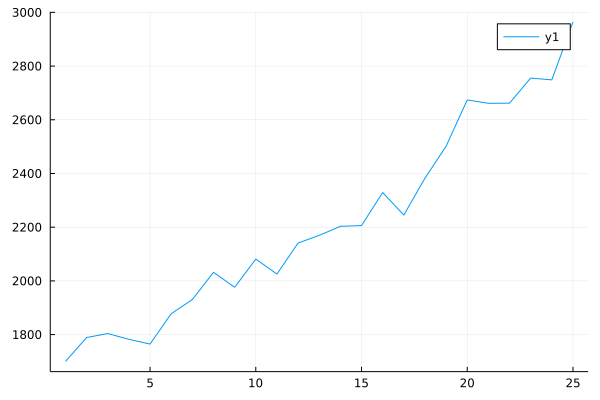

In [46]:
using Plots
#Expenditure / Wealth following fixed endowment
Exp=V[:,1]
plot(Exp)

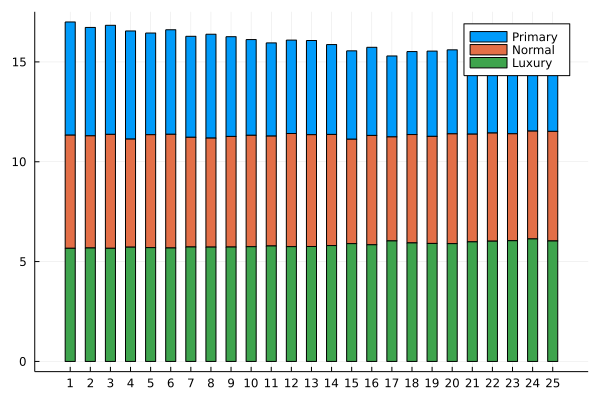

In [47]:
using StatsPlots
T=25
Primary=[]
Normal=[]
Luxury=[]
for t=1:T
    p=V[:,2][t][1]
    n=V[:,2][t][2]
    l=V[:,2][t][3]
    Primary=push!(Primary,p)
    Normal=push!(Normal,n)
    Luxury=push!(Luxury,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary Normal Luxury],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

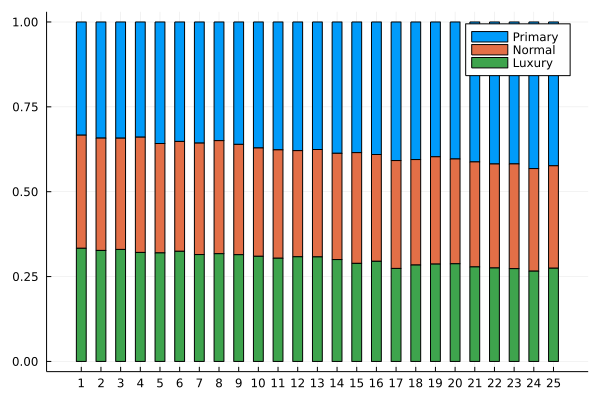

In [48]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=V[:,4][t][1]
    n=V[:,4][t][2]
    l=V[:,4][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

# Stone and Geary

In [7]:
#Function Stone and Geary
function SG(C::Vector{Int64}, cal)
    U=sum(cal.γ[i]*(C[i]+cal.κ[i])^ρ for i=1:length(C))^(1/ρ)
    return U
end

SG (generic function with 1 method)

# Non Homothetic Utility function

In [5]:
using NLsolve
u=1

#UTILITY LEVEL for a given C
function solvingNH(u, C::Vector{Float64}, cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

function NHUtility(u,C::Vector{Float64};cal=cal,tol=1e-10,T=1000)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    E=sum(cal.p[i]*C[i] for i=1:length(C))
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Minimum expenditure for the utility at given endowment level
    Expmini=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (cal.p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/Expmini)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/Expmini)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/Expmini)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/Expmini)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/Expmini)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/Expmini)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(cal.p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(cal.p[i]*C[i] for i =1:length(C)) 
        end
        return [U, Uinit, Expmini, E, ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtility (generic function with 1 method)

In [6]:
NHU=NHUtility(u,[10.0, 2.0, 2.0])
println("NH pref optimal utility level with no waste ", NHU[1])
println("Utility level reached at given endowment ", NHU[2])
println("Above can be reached with minimal cost ", NHU[3])
println("But we have to spend all the wealth so that there is no waste ", NHU[4])
println("Hence NH expenditure will coincide with the wealth ", NHU[5])
println("With bundle (updated) ", NHU[6])
println("Whereas endowment level utility can be reached with this bundle ", NHU[7])
println("Optimal share with no waste ", NHU[8])
println("Optimal share initial with waste ", NHU[9])

NH pref optimal utility level with no waste 13.388990206678397


Utility level reached at given endowment 6.903001683219594
Above can be reached with minimal cost 707.6379437007597
But we have to spend all the wealth so that there is no waste 1400.0
Hence NH expenditure will coincide with the wealth 1400.0000000000418
With bundle (updated) 

[3.520804354431771, 4.563695662429464, 5.915499983139183]
Whereas endowment level utility can be reached with this bundle [1.9204344716004786, 2.3297176549188188, 2.8262273104883]
Optimal share with no waste [0.25148602531655506, 0.3259782616021046, 0.4225357130813702]
Optimal share initial with waste [0.2713865881127167, 0.3292245244418368, 0.3993888874454466]


In [51]:
u=[]
C=[]

scale=5.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =NHUtility(u,[i,j,k])
            u=push!(u,res[1])
            C=push!(C,[i j k])
        end
    end
end

NH=[u C]


125×2 Matrix{Any}:
  2.97633  [1.0 1.0 1.0]
  3.95007  [1.0 1.0 2.0]
  4.91634  [1.0 1.0 3.0]
  5.87618  [1.0 1.0 4.0]
  6.83034  [1.0 1.0 5.0]
  3.95007  [1.0 2.0 1.0]
  4.91634  [1.0 2.0 2.0]
  5.87618  [1.0 2.0 3.0]
  6.83034  [1.0 2.0 4.0]
  7.77942  [1.0 2.0 5.0]
  ⋮        
 10.6006   [5.0 4.0 2.0]
 11.5333   [5.0 4.0 3.0]
 12.4627   [5.0 4.0 4.0]
 13.389    [5.0 4.0 5.0]
 10.6006   [5.0 5.0 1.0]
 11.5333   [5.0 5.0 2.0]
 12.4627   [5.0 5.0 3.0]
 13.389    [5.0 5.0 4.0]
 14.3122   [5.0 5.0 5.0]

In [7]:
using Plots, Distributions
histogram(NH[:,1]; bins = 0:0.5:15)


UndefVarError: UndefVarError: NH not defined

In [8]:
#Price dynamics
using Plots, DataFrames

function pricedynamics(T::Int64;cal=cal,N=3)
#Time and number of household considered
    #Get our price level dynamics
    shock_size=5
    index=100.0 
    pp=[cal.p[1]]  #price primary
    pn=[cal.p[2]]  #price normal
    pl=[cal.p[3]]  #price luxury
    agg=[1/N*(cal.p[1]+cal.p[2]+cal.p[3])] #aggregate price with homothetic

    for t=1:T-1
        p_p=100*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=100*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=100*cal.g[3]^(t)+shock_size*randn()
        agg_p=0.333*p_p+0.333*p_n+0.333*p_l #share coming from homothetic consumption bundle

        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)
        agg=push!(agg,agg_p)
    end

    pricesplot = [pp pn pl agg]
    return plot(pricesplot, title="Prices dynamics", label=["Primary" "Normal" "Luxury" "Aggregate"], lw=2)
end
    

pricedynamics (generic function with 1 method)

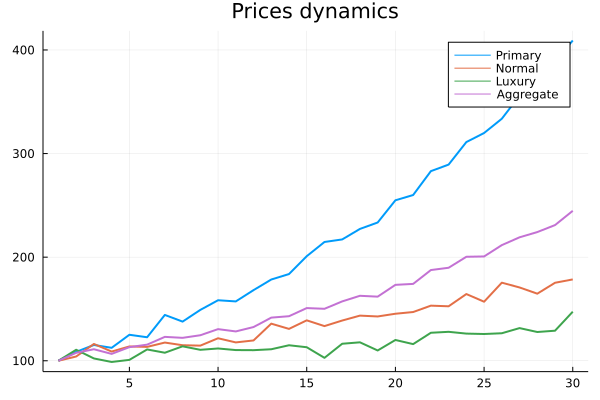

In [9]:
pricedynamics(30)

In [36]:
function prices(T::Int64 ;cal=cal)
    #Prices normalized at date t=1
    pp=[cal.p[1]]  #price primary
    pn=[cal.p[2]]  #price normal
    pl=[cal.p[3]]  #price luxury
    #Relative prices
    pnp_r=[1.0]
    pnl_r=[1.0]
    #AR(1)
    shock_size=5

    for t=1:T-1
        p_p=100*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=100*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=100*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)

        pnp_r=push!(pnp_r,pnp)
        pnl_r=push!(pnl_r,pnl)
        
    end
    return [pp pn pl pnp_r pnl_r]
end

T=30
p=prices(T)

data=DataFrame(p,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP",:"Relative P/N",:"Relative L/N"])

,Primary P,Normal P,LuxuryP,Relative P/N,Relative L/N
,Float64,Float64,Float64,Float64,Float64
1,100.0,100.0,100.0,1.0,1.0
2,98.5805,97.4448,97.7534,1.01165,1.00317
3,120.103,98.5412,104.875,1.21881,1.06427
4,120.429,102.013,102.071,1.18053,1.00058
5,121.414,106.04,108.103,1.14498,1.01946
6,135.156,105.655,101.604,1.27922,0.961655
7,135.447,115.683,107.415,1.17084,0.928528
8,137.895,123.477,101.67,1.11676,0.823388
9,154.287,124.723,102.624,1.23704,0.822812


In [37]:
p

30×5 Matrix{Float64}:
 100.0     100.0     100.0     1.0      1.0
  98.5805   97.4448   97.7534  1.01165  1.00317
 120.103    98.5412  104.875   1.21881  1.06427
 120.429   102.013   102.071   1.18053  1.00058
 121.414   106.04    108.103   1.14498  1.01946
 135.156   105.655   101.604   1.27922  0.961655
 135.447   115.683   107.415   1.17084  0.928528
 137.895   123.477   101.67    1.11676  0.823388
 154.287   124.723   102.624   1.23704  0.822812
 153.599   123.524   113.912   1.24348  0.922186
   ⋮                                    
 273.466   142.809   115.534   1.91491  0.809009
 298.739   160.006   126.058   1.86705  0.787834
 306.683   160.686   121.702   1.90859  0.757393
 320.811   161.113   124.704   1.99122  0.774018
 332.95    160.368   115.177   2.07616  0.718206
 345.938   164.357   135.597   2.1048   0.825018
 373.13    178.685   130.151   2.0882   0.72838
 389.323   169.561   133.13    2.29606  0.785142
 406.786   176.199   140.471   2.30867  0.797228

In [15]:
function NHUtilityExp(u,C::Vector{Float64}, E;cal=cal,tol=1e-10,T=1000)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Minimum expenditure for the utility at given endowment level
    Expmini=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (cal.p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/Expmini)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/Expmini)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/Expmini)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/Expmini)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/Expmini)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/Expmini)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(cal.p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (cal.p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (cal.p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (cal.p[3]/E)^(1-cal.σ)

            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(cal.p[i]*C[i] for i =1:length(C)) 
        end
        return [U, ExpNH, C, ω] #[U, Uinit, miniEforUinit, E,  ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtilityExp (generic function with 1 method)

In [38]:
function NHUtilitytime(u,C::Vector{Float64}, T ;cal=cal,tol=1e-10)
    u=1.0
    res = nlsolve(u->[solvingNH(u[1], C, cal)], [1.0])
    Exp=[]
    miniExp=[]
    Cons=[]
    Share=[]
    NH=[]
    Utility=[]

    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    for t=1:T
        #Wealth level
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #Minimum expenditure for the utility at given endowment level
        miniEforUinit=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[t,i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
        
        #Optimal demand with income effect
        c_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/miniEforUinit)^(-cal.σ)
        c_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/miniEforUinit)^(-cal.σ)
        c_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/miniEforUinit)^(-cal.σ)
        
        #Expenditure share with income effect
        ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/miniEforUinit)^(1-cal.σ)
        ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/miniEforUinit)^(1-cal.σ)
        ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/miniEforUinit)^(1-cal.σ)
        
        Consumption=[c_p, c_n, c_l]

        res=nlsolve(u->[solvingNH(u[1], Consumption, cal)], [1.0])
        U=res.zero[1]
        
        NHmax=NHUtilityExp(u,Consumption, E)
        Cons=push!(Cons, Consumption)
        
        ω=[ω_p, ω_n, ω_l]
        Share=push!(Share, ω)
        Utility=push!(Utility, U)

        Exp=push!(Exp,E)
        miniExp=push!(miniExp,miniEforUinit)
        NH=push!(NH, NHmax)
    end

    #STORE VALUE
    value=[]
    for v=1:4
        for t =1:T
        val=NH[t][v]
        value=push!(value,val)
        end
    end
    NH=(reshape(value,T,4))

    return [Utility Cons Share NH]
end

NHUtilitytime (generic function with 1 method)

In [39]:
p

30×5 Matrix{Float64}:
 100.0     100.0     100.0     1.0      1.0
  98.5805   97.4448   97.7534  1.01165  1.00317
 120.103    98.5412  104.875   1.21881  1.06427
 120.429   102.013   102.071   1.18053  1.00058
 121.414   106.04    108.103   1.14498  1.01946
 135.156   105.655   101.604   1.27922  0.961655
 135.447   115.683   107.415   1.17084  0.928528
 137.895   123.477   101.67    1.11676  0.823388
 154.287   124.723   102.624   1.23704  0.822812
 153.599   123.524   113.912   1.24348  0.922186
   ⋮                                    
 273.466   142.809   115.534   1.91491  0.809009
 298.739   160.006   126.058   1.86705  0.787834
 306.683   160.686   121.702   1.90859  0.757393
 320.811   161.113   124.704   1.99122  0.774018
 332.95    160.368   115.177   2.07616  0.718206
 345.938   164.357   135.597   2.1048   0.825018
 373.13    178.685   130.151   2.0882   0.72838
 389.323   169.561   133.13    2.29606  0.785142
 406.786   176.199   140.471   2.30867  0.797228

In [40]:
NHUtilitytime(u,[3.0, 4.0, 10.0], 30)

30×7 Matrix{Any}:
 14.6119  [3.81475, 4.98812, 6.5224]   …  [0.245996, 0.324898, 0.429106]
 14.6119  [3.80075, 4.99869, 6.5259]      [0.246613, 0.325023, 0.428363]
 14.6119  [3.59137, 5.18441, 6.57118]     [0.244345, 0.324556, 0.431099]
 14.6119  [3.58702, 5.09616, 6.66175]     [0.24455, 0.324599, 0.430851]
 14.6119  [3.6419, 5.09564, 6.59909]      [0.243338, 0.324344, 0.432318]
 14.6119  [3.45504, 5.1097, 6.81329]   …  [0.243718, 0.324425, 0.431857]
 14.6119  [3.54287, 5.01273, 6.80217]     [0.24226, 0.324114, 0.433625]
 14.6119  [3.51858, 4.86204, 7.00627]     [0.242533, 0.324173, 0.433295]
 14.6119  [3.39003, 4.93022, 7.107]       [0.241628, 0.323978, 0.434394]
 14.6119  [3.46118, 5.04678, 6.87188]     [0.240189, 0.323663, 0.436148]
  ⋮                                    ⋱  
 14.6119  [2.90211, 5.2512, 7.634]        [0.234816, 0.322435, 0.442749]
 14.6119  [2.9129, 5.20444, 7.66703]      [0.232277, 0.321826, 0.445898]
 14.6119  [2.87106, 5.18644, 7.79255]     [0.232442, 0.321866, 0.

In [41]:
X=NHUtilitytime(u,[3.0, 5.0, 10.0], 30)
Umin=X[:,[1,4]];
C=X[:,[2,6]];
Share=X[:,[3,7]];
Exp=X[:,5];

In [48]:
Umin

30×2 Matrix{Any}:
 15.9129  17.0657
 15.9129  16.7044
 15.9129  17.9945
 15.9129  17.9061
 15.9129  18.6658
 15.9129  18.432
 15.9129  19.4242
 15.9129  19.323
 15.9129  19.9124
 15.9129  20.8619
  ⋮       
 15.9129  25.1125
 15.9129  27.4987
 15.9129  27.3532
 15.9129  28.0173
 15.9129  27.4598
 15.9129  29.7996
 15.9129  30.6752
 15.9129  30.9653
 15.9129  32.3711

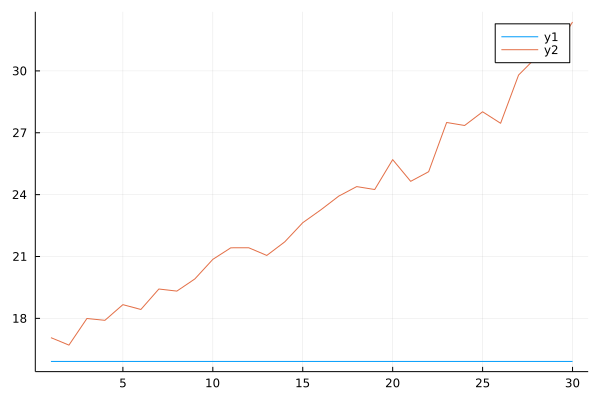

In [53]:
plot(Umin[:,1])
plot!(Umin[:,2])

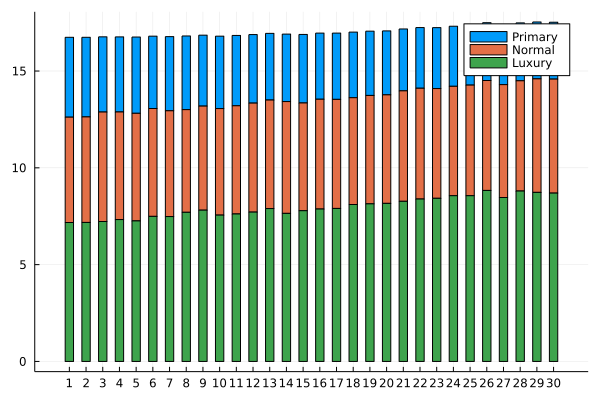

In [43]:
using StatsPlots
Primary=[]
Normal=[]
Luxury=[]
for t=1:T
    p=C[:,1][t][1]
    n=C[:,1][t][2]
    l=C[:,1][t][3]
    Primary_s=push!(Primary,p)
    Normal_s=push!(Normal,n)
    Luxury_s=push!(Luxury,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary Normal Luxury],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

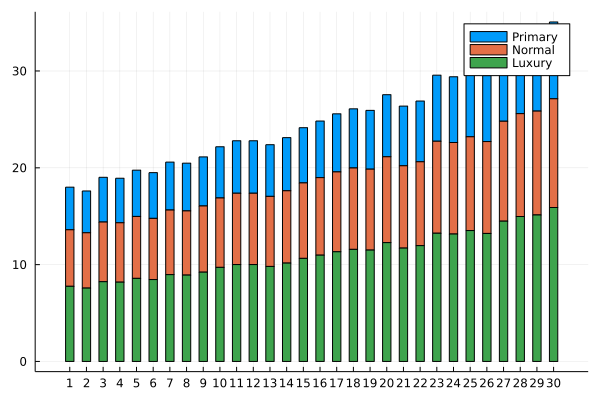

In [44]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=C[:,2][t][1]
    n=C[:,2][t][2]
    l=C[:,2][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

In [45]:
Share

30×2 Matrix{Any}:
 [0.246427, 0.324986, 0.428587]  [0.244395, 0.324567, 0.431039]
 [0.247337, 0.324301, 0.428361]  [0.245015, 0.324696, 0.430289]
 [0.261796, 0.312731, 0.425473]  [0.24286, 0.324243, 0.432897]
 [0.262128, 0.318163, 0.41971]   [0.243003, 0.324273, 0.432724]
 [0.25816, 0.318174, 0.423666]   [0.241803, 0.324016, 0.434181]
 [0.272186, 0.317372, 0.410443]  [0.242167, 0.324094, 0.433739]
 [0.265421, 0.323491, 0.411088]  [0.240656, 0.323766, 0.435578]
 [0.267285, 0.333556, 0.399159]  [0.240806, 0.323799, 0.435395]
 [0.277458, 0.328988, 0.393555]  [0.239943, 0.323609, 0.436448]
 [0.271709, 0.321337, 0.406954]  [0.238608, 0.323311, 0.438082]
 ⋮                               
 [0.32431, 0.309073, 0.366617]   [0.233333, 0.322082, 0.444585]
 [0.32311, 0.311851, 0.365039]   [0.230776, 0.321456, 0.447768]
 [0.327847, 0.312961, 0.359192]  [0.230925, 0.321493, 0.447582]
 [0.331244, 0.309574, 0.359182]  [0.230252, 0.321326, 0.448423]
 [0.340346, 0.311505, 0.348148]  [0.230816, 0.321466,

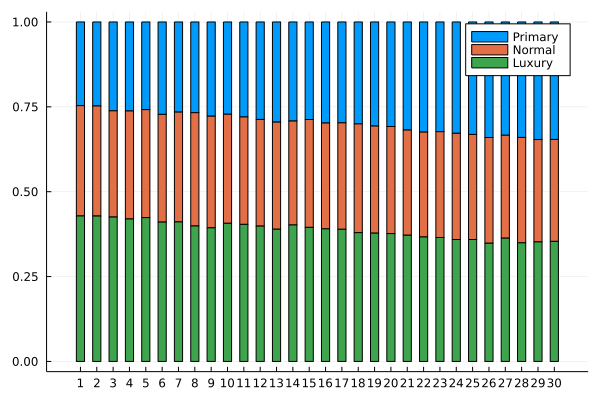

In [46]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=Share[:,1][t][1]
    n=Share[:,1][t][2]
    l=Share[:,1][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

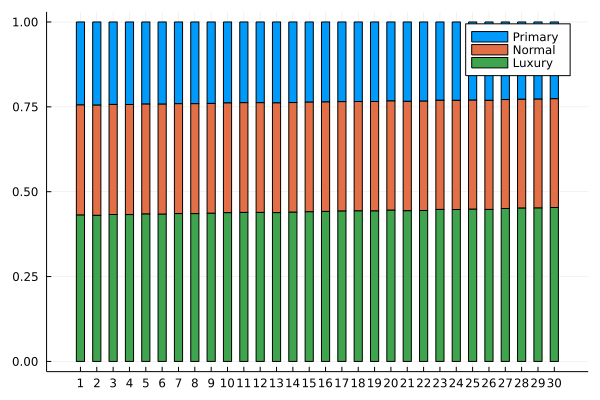

In [47]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=Share[:,2][t][1]
    n=Share[:,2][t][2]
    l=Share[:,2][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])